In [2]:

import os
import sys
import logging
from datetime import datetime
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve
)
import joblib


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


os.makedirs("logs", exist_ok=True)
log_filename = f"logs/log_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"
logging.basicConfig(
    filename=log_filename,
    level=logging.INFO,
    format="%(asctime)s %(levelname)s %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)
console = logging.StreamHandler(sys.stdout)
console.setLevel(logging.INFO)
formatter = logging.Formatter("%(asctime)s %(levelname)s %(message)s", "%Y-%m-%d %H:%M:%S")
console.setFormatter(formatter)
logging.getLogger().addHandler(console)

logging.info("Environment setup complete")


2025-11-02 00:22:36 INFO Environment setup complete


Clicked on Ad
0    0.5
1    0.5
Name: proportion, dtype: float64
2025-11-02 00:29:23 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-02 00:29:23 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


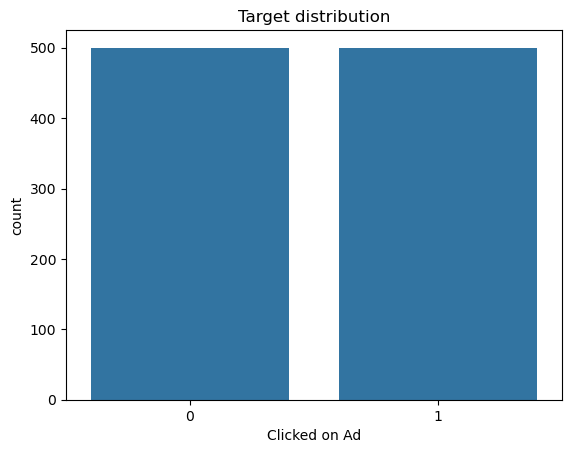

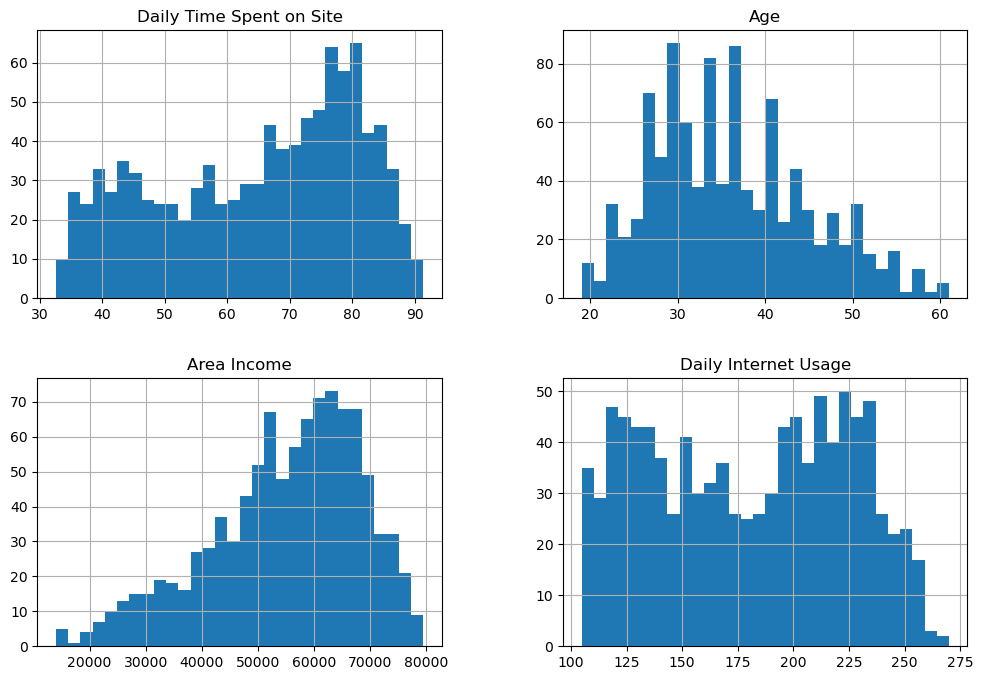

2025-11-02 00:29:24 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-02 00:29:24 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


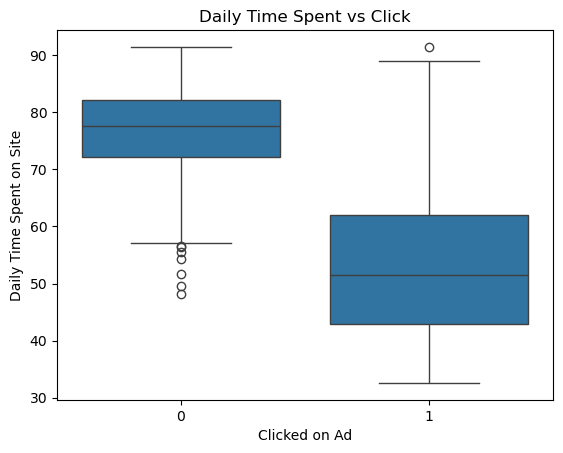

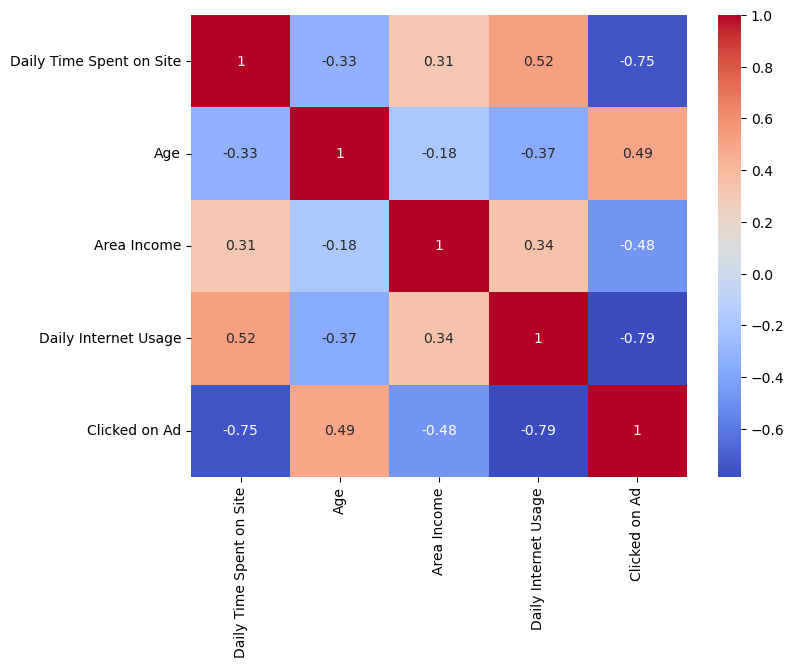

In [25]:

import matplotlib.pyplot as plt
%matplotlib inline


target_col = "Clicked on Ad"  
print(df[target_col].value_counts(normalize=True))
sns.countplot(x=target_col, data=df)
plt.title("Target distribution")
plt.show()

num_cols = ["Daily Time Spent on Site", "Age", "Area Income", "Daily Internet Usage"]
df[num_cols].hist(bins=30, figsize=(12,8))
plt.show()


sns.boxplot(x=target_col, y="Daily Time Spent on Site", data=df)
plt.title("Daily Time Spent vs Click")
plt.show()


plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols + [target_col]].corr(), annot=True, cmap="coolwarm")
plt.show()


In [6]:
# cell 5: category checks
print(df["Male"].value_counts() if "Male" in df.columns else "No Male column")
print(df["Country"].value_counts().head(10) if "Country" in df.columns else "No Country")
print("Sample Ad Topic Lines:")
print(df["Ad Topic Line"].sample(10).values)


Male
0    519
1    481
Name: count, dtype: int64
Country
Czech Republic    9
France            9
Senegal           8
Peru              8
Greece            8
Micronesia        8
Liberia           8
Turkey            8
Afghanistan       8
South Africa      8
Name: count, dtype: int64
Sample Ad Topic Lines:
['Customizable holistic archive'
 'Self-enabling zero administration neural-net'
 'Quality-focused maximized extranet' 'Organic logistical adapter'
 'Inverse high-level capability' 'Digitized interactive initiative'
 'Implemented disintermediate attitude'
 'Upgradable heuristic system engine' 'Managed national hardware'
 'Multi-layered user-facing paradigm']


In [7]:

df = df.copy()


if "Timestamp" in df.columns:
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])

    df["hour"] = df["Timestamp"].dt.hour
    df["dayofweek"] = df["Timestamp"].dt.dayofweek


if "Ad Topic Line" in df.columns:
    df["ad_topic_len"] = df["Ad Topic Line"].astype(str).apply(len)
    
    df["ad_topic_words"] = df["Ad Topic Line"].astype(str).apply(lambda x: len(x.split()))


if "Male" in df.columns:
    df["gender"] = df["Male"].map({1: "male", 0: "female"})
    df.drop(columns=["Male"], inplace=True)


cols_to_drop = []
for col in ["City", "Ad Topic Line", "Timestamp"]:
    if col in df.columns:
        cols_to_drop.append(col)
df.drop(columns=cols_to_drop, inplace=True)
logging.info(f"Dropped columns: {cols_to_drop}")

df.head()


2025-11-02 00:22:39 INFO Dropped columns: ['City', 'Ad Topic Line', 'Timestamp']


,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Country,Clicked on Ad,hour,dayofweek,ad_topic_len,ad_topic_words,gender
0,68.95,35,61833.90,256.09,Tunisia,0,0,6,34,3,female
1,80.23,31,68441.85,193.77,Nauru,0,1,0,34,3,male
2,69.47,26,59785.94,236.50,San Marino,0,20,6,32,3,female
3,74.15,29,54806.18,245.89,Italy,0,2,6,37,3,male
4,68.37,35,73889.99,225.58,Iceland,0,3,4,29,3,female


In [8]:

target = "Clicked on Ad"
all_features = [c for c in df.columns if c != target]
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [c for c in numeric_features if c != target]

categorical_features = [c for c in df.columns if c not in numeric_features + [target]]
logging.info(f"Numeric: {numeric_features}, Categorical: {categorical_features}")


2025-11-02 00:22:39 INFO Numeric: ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage', 'hour', 'dayofweek', 'ad_topic_len', 'ad_topic_words'], Categorical: ['Country', 'gender']


In [9]:

from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  # Changed 'sparse' to 'sparse_output'
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
], remainder='drop')


In [10]:

X = df[all_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)
logging.info(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


2025-11-02 00:22:40 INFO Train shape: (750, 10), Test shape: (250, 10)


In [11]:

lr_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
])

lr_pipeline.fit(X_train, y_train)
y_pred = lr_pipeline.predict(X_test)
y_proba = lr_pipeline.predict_proba(X_test)[:,1]

# metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)
logging.info(f"Logistic Regression metrics - ACC: {acc:.4f}, PREC: {prec:.4f}, REC: {rec:.4f}, F1: {f1:.4f}, AUC: {roc:.4f}")

print(classification_report(y_test, y_pred))


2025-11-02 00:22:41 INFO Logistic Regression metrics - ACC: 0.9760, PREC: 0.9837, REC: 0.9680, F1: 0.9758, AUC: 0.9908
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       125
           1       0.98      0.97      0.98       125

    accuracy                           0.98       250
   macro avg       0.98      0.98      0.98       250
weighted avg       0.98      0.98      0.98       250



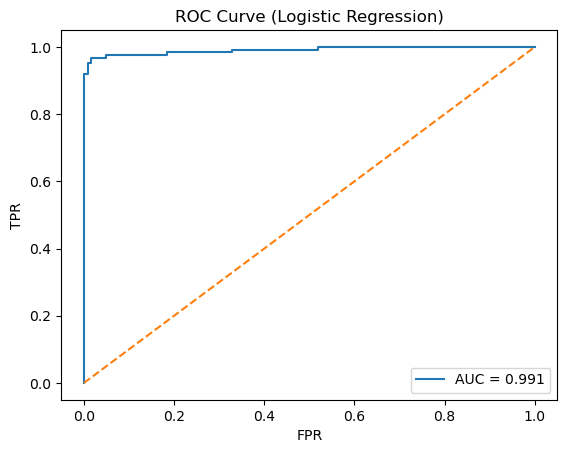

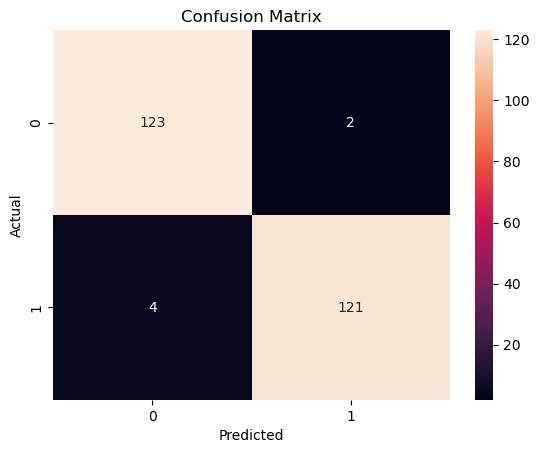

In [12]:

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc:.3f}")
plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve (Logistic Regression)")
plt.legend()
plt.show()

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [13]:

os.makedirs("models", exist_ok=True)
model_path = "models/logistic_pipeline.joblib"
joblib.dump(lr_pipeline, model_path)
logging.info(f"Saved pipeline to {model_path}")


pred_df = X_test.copy()
pred_df["actual"] = y_test.values
pred_df["predicted"] = y_pred
pred_df["pred_proba"] = y_proba
pred_out_path = "models/test_predictions.csv"
pred_df.to_csv(pred_out_path, index=False)
logging.info(f"Saved test predictions to {pred_out_path}")


metrics = {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "auc": roc}
with open("models/metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)
logging.info("Saved metrics to models/metrics.json")


2025-11-02 00:22:42 INFO Saved pipeline to models/logistic_pipeline.joblib
2025-11-02 00:22:42 INFO Saved test predictions to models/test_predictions.csv
2025-11-02 00:22:42 INFO Saved metrics to models/metrics.json


In [14]:

param_grid = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs"]
}

gs = GridSearchCV(lr_pipeline, param_grid, cv=5, scoring="roc_auc", n_jobs=-1)
gs.fit(X_train, y_train)
logging.info(f"Best params: {gs.best_params_}, best score: {gs.best_score_:.4f}")

best_model = gs.best_estimator_
y_pred_gs = best_model.predict(X_test)
y_proba_gs = best_model.predict_proba(X_test)[:,1]
logging.info(f"Tuned LR AUC: {roc_auc_score(y_test, y_proba_gs):.4f}")


2025-11-02 00:22:53 INFO Best params: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}, best score: 0.9906
2025-11-02 00:22:53 INFO Tuned LR AUC: 0.9908


In [15]:

rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE))
])
rf_pipeline.fit(X_train, y_train)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:,1]
logging.info(f"RandomForest AUC: {roc_auc_score(y_test, y_proba_rf):.4f}")


2025-11-02 00:22:54 INFO RandomForest AUC: 0.9874


In [16]:

preproc = best_model.named_steps["preprocessor"]

num_feats = numeric_features

cat_transform = preproc.named_transformers_["cat"].named_steps["onehot"]
cat_feats = cat_transform.get_feature_names_out(categorical_features).tolist()
feature_names = num_feats + cat_feats

coef = best_model.named_steps["clf"].coef_[0]
feat_imp = pd.DataFrame({"feature": feature_names, "coef": coef})
feat_imp["abs_coef"] = feat_imp["coef"].abs()
feat_imp.sort_values("abs_coef", ascending=False).head(20)


,feature,coef,abs_coef
0,Daily Time Spent on Site,-2.807347,2.807347
3,Daily Internet Usage,-2.361024,2.361024
2,Area Income,-1.599245,1.599245
1,Age,1.177795,1.177795
46,Country_Cayman Islands,1.027285,1.027285
62,Country_Denmark,0.989843,0.989843
20,Country_Australia,0.952729,0.952729
208,Country_Sweden,-0.841494,0.841494
102,Country_Hungary,0.789346,0.789346
115,Country_Kazakhstan,0.741190,0.741190


In [17]:
import sys
import argparse

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--data", default="advertising.csv")
    parser.add_argument("--out", default="models")
    # ignore Jupyter args
    args, unknown = parser.parse_known_args()
    return args

def main():
    args = parse_args()
    print("Data path:", args.data)
    print("Output folder:", args.out)
    # your training code here

if __name__ == "__main__":
    main()


Data path: advertising.csv
Output folder: models


In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# --- Accuracy ---
acc = accuracy_score(y_test, y_pred)
print(f"\nAccuracy of Model: {acc*100:.2f}%\n")

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix\n")
print("Predicted 0\tPredicted 1")
print(f"Actual 0\t{cm[0][0]}\t\t{cm[0][1]}")
print(f"Actual 1\t{cm[1][0]}\t\t{cm[1][1]}\n")

# --- Classification Report ---
print("Classification Report\n")
print(classification_report(y_test, y_pred, digits=2))



Accuracy of Model: 97.60%

Confusion Matrix

Predicted 0	Predicted 1
Actual 0	123		2
Actual 1	4		121

Classification Report

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       125
           1       0.98      0.97      0.98       125

    accuracy                           0.98       250
   macro avg       0.98      0.98      0.98       250
weighted avg       0.98      0.98      0.98       250



In [19]:

import json
metrics = json.load(open("models/metrics.json"))
print("Accuracy of Model: {:.2f}%".format(metrics["accuracy"]*100))
print("\nConfusion matrix (from saved test_predictions.csv):")
import pandas as pd
pred = pd.read_csv("models/test_predictions.csv")
# compute confusion
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(pred['actual'], pred['predicted'])
print("Predicted 0\tPredicted 1")
print(f"Actual 0\t{cm[0,0]}\t\t{cm[0,1]}")
print(f"Actual 1\t{cm[1,0]}\t\t{cm[1,1]}")
print("\nClassification Report:\n")
from sklearn.metrics import classification_report
print(classification_report(pred['actual'], pred['predicted'], digits=2))



Accuracy of Model: 97.60%

Confusion matrix (from saved test_predictions.csv):
Predicted 0	Predicted 1
Actual 0	123		2
Actual 1	4		121

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       125
           1       0.98      0.97      0.98       125

    accuracy                           0.98       250
   macro avg       0.98      0.98      0.98       250
weighted avg       0.98      0.98      0.98       250



Clicked on Ad
0    0.5
1    0.5
Name: proportion, dtype: float64
2025-11-02 00:52:52 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-02 00:52:52 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


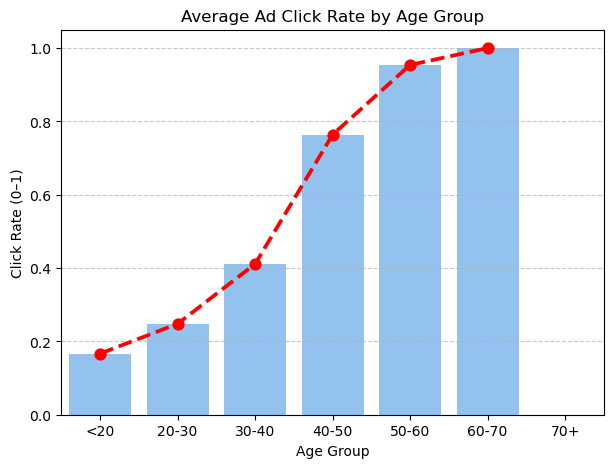

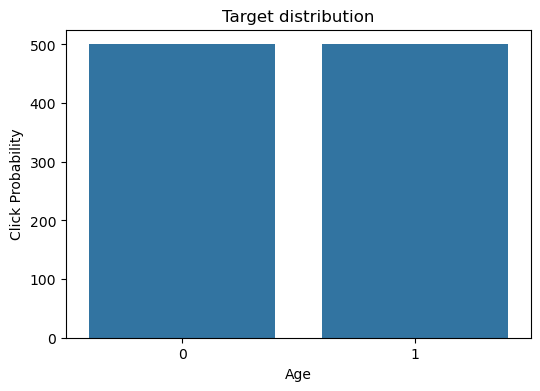

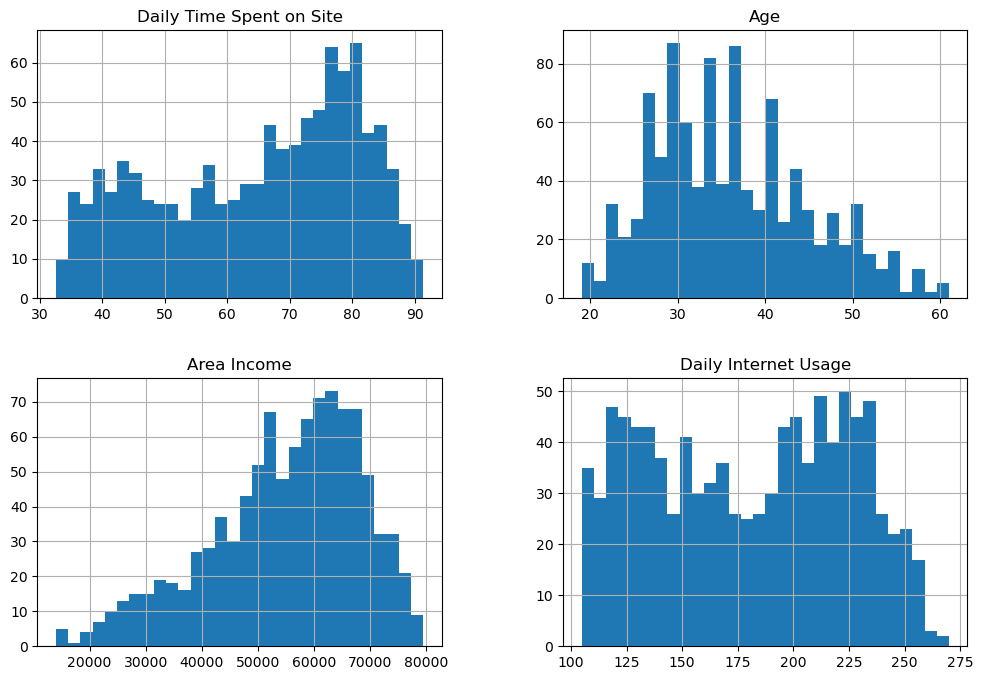

2025-11-02 00:52:54 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-02 00:52:54 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


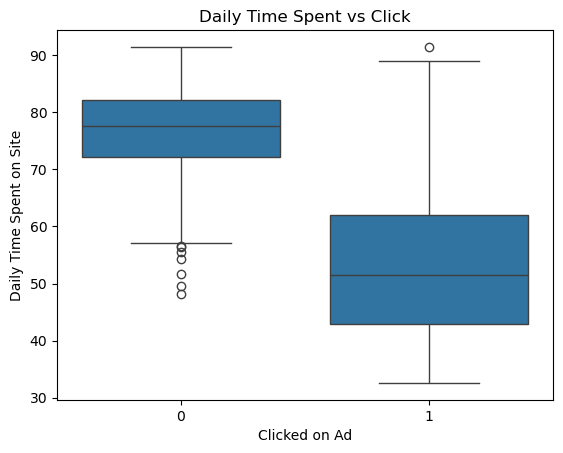

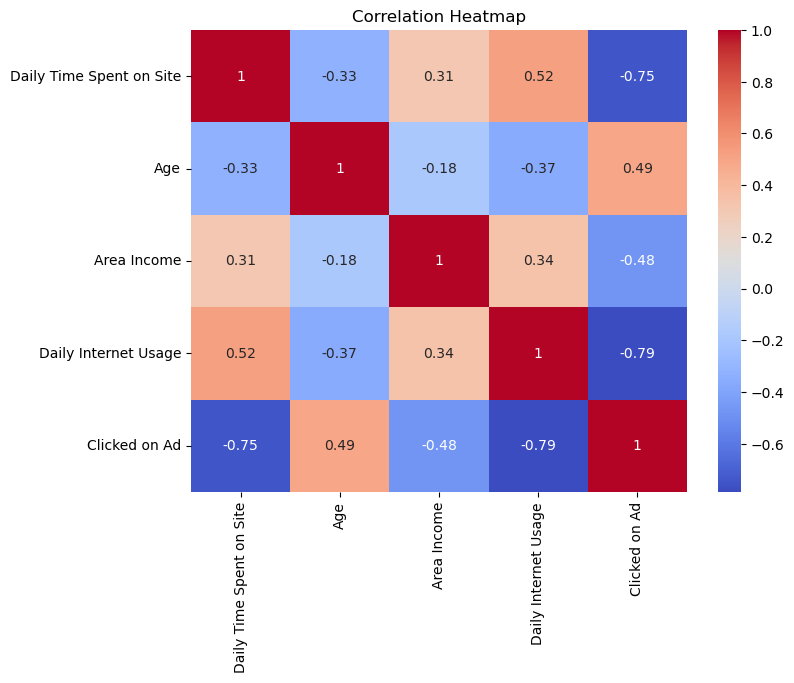

2025-11-02 00:52:55 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-02 00:52:55 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


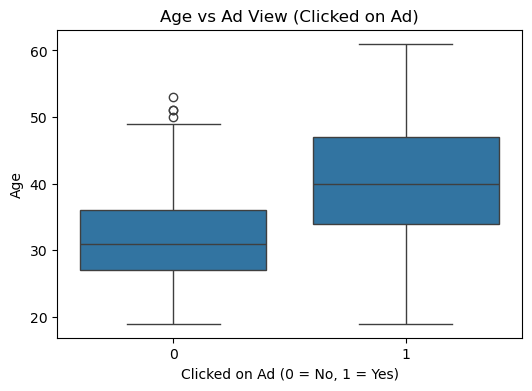

In [28]:
# Cell 4: distributions & target balance
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Target distribution
target_col = "Clicked on Ad"  # adjust if different
print(df[target_col].value_counts(normalize=True))
sns.countplot(x=target_col, data=df)
plt.title("Target distribution")
plt.show()

# Numeric distribution examples
num_cols = ["Daily Time Spent on Site", "Age", "Area Income", "Daily Internet Usage"]
df[num_cols].hist(bins=30, figsize=(12,8))
plt.show()

# Boxplot: Time spent vs clicked
sns.boxplot(x=target_col, y="Daily Time Spent on Site", data=df)
plt.title("Daily Time Spent vs Click")
plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols + [target_col]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# ✅ New visualization: Age vs Ad View (Clicked on Ad)
plt.figure(figsize=(6,4))
sns.boxplot(x=target_col, y="Age", data=df)
plt.title("Age vs Ad View (Clicked on Ad)")
plt.xlabel("Clicked on Ad (0 = No, 1 = Yes)")
plt.ylabel("Age")
plt.show()


2025-11-02 01:01:13 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-02 01:01:14 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


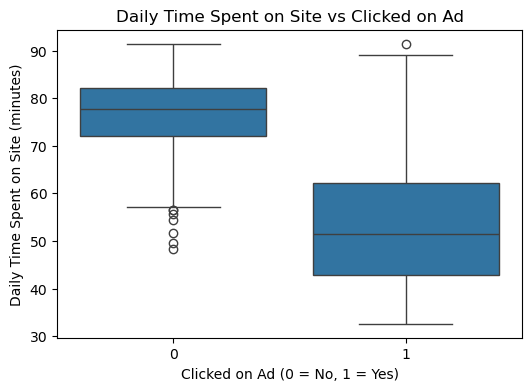

2025-11-02 01:01:14 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-02 01:01:14 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


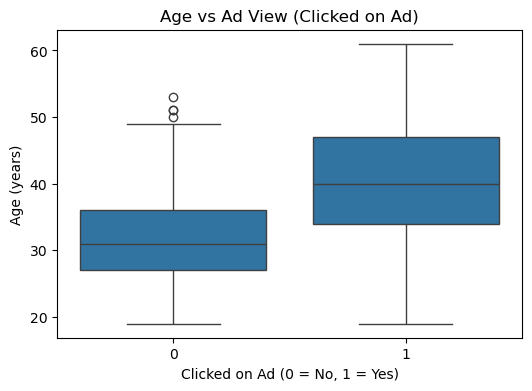

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

target_col = "Clicked on Ad"  # target column

# ✅ 1. Time Spent vs Clicked
plt.figure(figsize=(6,4))
sns.boxplot(x=target_col, y="Daily Time Spent on Site", data=df)
plt.title("Daily Time Spent on Site vs Clicked on Ad")
plt.xlabel("Clicked on Ad (0 = No, 1 = Yes)")
plt.ylabel("Daily Time Spent on Site (minutes)")
plt.show()

# ✅ 2. Age vs Ad View (Clicked)
plt.figure(figsize=(6,4))
sns.boxplot(x=target_col, y="Age", data=df)
plt.title("Age vs Ad View (Clicked on Ad)")
plt.xlabel("Clicked on Ad (0 = No, 1 = Yes)")
plt.ylabel("Age (years)")
plt.show()
